# Calculating Origin Destinations nXn Matrix given set of origins and destinations

<h2>Table of Contents<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"><li><span><a href="#Origin-Destinations-nXn-Matrix-given-set-of-origins-and-destinations" data-toc-modified-id="Origin-Destinations-nXn-Matrix-given-set-of-origins-and-destinations-1">Origin Destinations nXn Matrix given set of origins and destinations</a></span><ul class="toc-item"><li><span><a href="#Create-origins-layer:" data-toc-modified-id="Create-origins-layer:-1.1">Create origins layer:</a></span></li><li><span><a href="#Create-destinations-layer:" data-toc-modified-id="Create-destinations-layer:-1.2">Create destinations layer:</a></span></li><li><span><a href="#Convert-to-matrix-format" data-toc-modified-id="Convert-to-matrix-format-1.3">Convert to matrix format</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.4">Conclusion</a></span></li></ul></li></ul></div>


The [Origin Destination(OD) Cost Matrix service](http://desktop.arcgis.com/en/arcmap/latest/extensions/network-analyst/od-cost-matrix.htm) helps you to create an OD cost matrix for multiple `origins` to multiple `destinations`. An OD cost matrix is a table that contains cost, such as travel time or travel distance, from each origin to each destination. Additionally, it ranks the destinations in ascending order based on the minimum cost required to travel. When generating an OD cost matrix, you can optionally specify the maximum number of destinations to find for each origin and the maximum time or distance to travel when searching for destinations.

By default, the matrix is generated with columns - origin id, destination id, destination rank, total time and total distance. 
In this sample notebook , we will use this tool to get OD matrix if given a set of origin and destination points, either as a csv with latitude and longitude or csv file with list of addresses. In later part of this sample, we will format the table to get n by n matrix.

This is useful when you want to solve other transportation problems with open source tools or heuristics. When it comes to real world TSP(Travelling Salesman Problem) or VRP(Vehicle Routing Problem) or other tranportation problems, data about travel time from every point to every other point can give you more realistic results than with euclidean distance.

**Note** :If you run the tutorial using ArcGIS Online, 0.003 [credit](https://www.esri.com/en-us/arcgis/products/arcgis-online/pricing/credits) will be consumed as there are 6 origin-destination pairs.

As a first step, let's import required libraries and establish a connection to your organization which could be an ArcGIS Online organization or an ArcGIS Enterprise. If you dont have an ArcGIS account, [get ArcGIS Trial](https://www.esri.com/en-us/arcgis/trial).

In [8]:
import arcgis
from arcgis.gis import GIS
import pandas as pd
import datetime
import getpass
from IPython.display import HTML

from arcgis import geocoding
from arcgis.features import Feature, FeatureSet
from arcgis.features import GeoAccessor, GeoSeriesAccessor

In [2]:
portal_url = 'https://wwww.arcgis.com'
#connect to your GIS
user_name = '<user_name>'
password = '<password>'
my_gis = GIS(portal_url, user_name, password)

We will see how to create layer for origins and destinations when we have latitude and longitude and when we have addresses to geocode for converting to layer respectively.

## Create origins layer:

We have latitude and longitude information for origins, with the following code snippet, we can create a layer from the information. We will reverse geocode the latitude longitude information to find the locations.

**Note**: Geocoding the addresses will consume [credits](https://www.esri.com/en-us/arcgis/products/arcgis-online/pricing/credits).

In [6]:
origin_coords = ['-117.187807, 33.939479', '-117.117401, 34.029346']
origin_features = []

for origin in origin_coords:
    reverse_geocode = geocoding.reverse_geocode({"x": origin.split(',')[0], 
                                              "y": origin.split(',')[1]})    

    origin_feature = Feature(geometry=reverse_geocode['location'], 
                           attributes=reverse_geocode['address'])
    origin_features.append(origin_feature)

origin_fset = FeatureSet(origin_features, geometry_type='esriGeometryPoint',
                          spatial_reference={'latestWkid': 4326})
origin_fset

<FeatureSet> 2 features

## Create destinations layer:

We have address information for the destinations in a csv file, with the following code snippet, we can geocode the addresses to create a destination layer. You could [batch geocode](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geocoding.html#batch-geocode) the addresses if you have a list of addresses. 

**Note**: Geocoding the addresses will consume credits.

In [9]:
# Read csv files from data:
destinations_address = r"data/destinations_address.csv"
destinations_df = pd.read_csv(destinations_address)
destinations_sdf = pd.DataFrame.spatial.from_df(destinations_fc, "Address")
destinations_sdf.head()

,Address,SHAPE
0,"1151 W Lugonia Ave, Redlands, CA 92374","{""x"": -117.19844792399999, ""y"": 34.07009573400..."
1,"1099 E Hospitality Ln, San Bernardino, CA 92408","{""x"": -117.26305030299994, ""y"": 34.06887554900..."
2,"4756, 120 E State St, Redlands, CA 92373","{""x"": -117.18077399999999, ""y"": 34.05639548800..."


In [10]:
destinations_fset = destinations_sdf.spatial.to_featureset()
destinations_fset

<FeatureSet> 3 features

With these inputs, solve the problem with Origin Destintion matrix solver. Look up [the doc](https://developers.arcgis.com/rest/network/api-reference/origin-destination-cost-matrix-service.htm) to understand how this tool works and its parameters. Remember, `0.0005` credits per input origin and destination pair will be charged. For example, if there are `100` origins and `200` destinations, the cost will be `10` credits. If you specify a cutoff or limit the number of destinations, for instance, to find only `5` closest destinations within `10` minutes of every origin, the cost will still be `10` credits, as the credits depend on the number of input origin destination pairs. 

`TargetDestinationCount`- The maximum number of destinations that must be found for the origin. If a value is not specified, the value from the Number of Destinations to Find parameter is used. 

`Cutoff`- Specify the travel time or travel distance value at which to stop searching for destinations from the origin. Any destination beyond the cutoff value will not be considered. The value needs to be in the units specified by the Time Units parameter if the impedance attribute in your travel mode is time based or in the units specified by the Distance Units parameter if the impedance attribute in your travel mode is distance based. If a value is not specified, the tool will not enforce any travel time or travel distance limit when searching for destinations.

Specify `origin_destination_line_shape` to see the output in map. Even though the lines are straight for performance reasons, they always store the travel time and travel distance along the street network, not straight-line distance.

In [12]:
%%time
# solve OD cost matrix tool for the origns and destinations
from arcgis.network.analysis import generate_origin_destination_cost_matrix
results = generate_origin_destination_cost_matrix(origins= origin_fset, #origins_fc_latlong, 
                                                destinations= destinations_fset, #destinations_fs_address,
                                                cutoff=200,
                                                origin_destination_line_shape='Straight Line')
print('Analysis succeeded? {}'.format(results.solve_succeeded))

Analysis succeeded? True
CPU times: user 379 ms, sys: 27.1 ms, total: 406 ms
Wall time: 24.7 s


Let's see the output lines table. 

In [15]:
od_df = results.output_origin_destination_lines.sdf
od_df

,DestinationOID,DestinationRank,OBJECTID,OriginOID,SHAPE,Shape_Length,Total_Distance,Total_Time
0,3,1,1,1,"{""paths"": [[[-117.18779101399997, 33.939597752...",0.117008,21.832442,24.159862
1,1,2,2,1,"{""paths"": [[[-117.18779101399997, 33.939597752...",0.130932,23.262677,24.910770
2,2,3,3,1,"{""paths"": [[[-117.18779101399997, 33.939597752...",0.149588,26.421002,27.939439
3,1,1,4,2,"{""paths"": [[[-117.11711694599995, 34.028605892...",0.091302,9.965429,7.510600
4,3,2,5,2,"{""paths"": [[[-117.11711694599995, 34.028605892...",0.069458,8.269718,8.067540
5,2,3,6,2,"{""paths"": [[[-117.11711694599995, 34.028605892...",0.151388,16.558662,13.764840


## Convert to matrix format
We need to change the format to get a matrix with rows as origins and columns as destinations, with impedance value as travel time or travel distance. We will use the `pivot_table` feature of Pandas to accomplish that.

In [29]:
# filter only the required columns
od_df2 = od_df[['DestinationOID','OriginOID','Total_Distance','Total_Time']]

# user pivot_table
od_pivot = od_df2.pivot_table(index='OriginOID', columns='DestinationOID')
od_pivot

Total_Distance                       Total_Time             \
DestinationOID              1          2          3          1          2   
OriginOID                                                                   
1                   23.262677  26.421002  21.832442   24.91077  27.939439   
2                    9.965429  16.558662   8.269718    7.51060  13.764840   

                           
DestinationOID          3  
OriginOID                  
1               24.159862  
2                8.067540

Write the pivot table to disk

In [30]:
od_pivot.to_csv('data/OD_Matrix.csv')

This is how we can get OD cost matrix when we have csv files with origin and destinations location information. We could read this matrix and provide this as input to a heuristics or an open-source algorithm. 


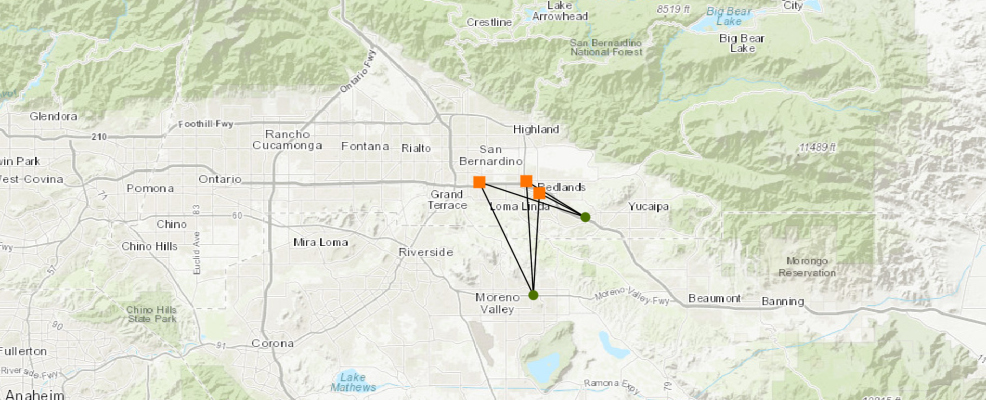

In [25]:
od_map = my_gis.map('Loma Linda, CA')
od_map

In [23]:
od_map.draw(results.output_origin_destination_lines)
od_map.draw(destinations_fset, symbol={"type": "esriSMS","style": "esriSMSSquare","color": [255,115,0,255], "size": 10})
od_map.draw(origin_fset, symbol={"type": "esriSMS","style": "esriSMSCircle","color": [76,115,0,255],"size": 8})

## Conclusion
This sample demonstrated how you can constuct an OD cost matrix using the Python API. We stared by defining `2` origin and `3` destination points. We used the `generate_origin_destination_cost_matrix()` method under the `network` module to compute the OD cost matrix.

### How can you use this?
The OD cost matrix becomes an important analytical output for downstream routing and other network analysis problems. Imagine you run a pizza shop and receive orders for delivery in a central location. Based on the distance to these demand points, you need to decide which supply point (pizza shop) should service which demand point (customer address). You can solve problems such as these by computing the OD cost matrix.